In [1]:
#Reading in the AG News Dataset
import glob
import pandas as pd
ag_news = glob.glob('./archive-2/*.csv')
#Make an empty list
df_list = []
#Convert the files into pandas dataframe
for file in ag_news:
    df = pd.read_csv(file)
    #Append the dataframe to the list
    df_list.append(df)

#Use pandas concat function to make all the dataframes into one
ag_news_pd = pd.concat(df_list,ignore_index=True)

#Sanity Check
print(ag_news_pd.head())
print(ag_news_pd.columns)
    


   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2            4      Ky. Company Wins Grant to Study Peptides (AP)   
3            4      Prediction Unit Helps Forecast Wildfires (AP)   
4            4        Calif. Aims to Limit Farm-Related Smog (AP)   

                                         Description  
0  Unions representing workers at Turner   Newall...  
1  SPACE.com - TORONTO, Canada -- A second\team o...  
2  AP - A company founded by a chemistry research...  
3  AP - It's barely dawn when Mike Fitzpatrick st...  
4  AP - Southern California's smog-fighting agenc...  
Index(['Class Index', 'Title', 'Description'], dtype='object')


In [2]:
#Concatenate the two columns (Title and Description)together
ag_news_pd['Text'] = ag_news_pd['Title'].astype(str) + " " + ag_news_pd['Description'].astype(str)

In [3]:
import nltk
from nltk.tokenize import word_tokenize

#This is a function to tokenize the dataset
def word_tokenizer(text):
    #use nltk's word tokenize function
    tokens = word_tokenize(text)
    tokens = ['[CLS]'] + tokens  # Add CLS token at position 0
    return tokens


def pad_truncate(text,max_sentence_length=128, pad_token="<pad>"):
    #If the sentence is over 128
    if len(text) > max_sentence_length:
        text = text[:max_sentence_length]
    #If the sentence is less then or equal to 128, pad it it with the pad_token
    return text + [pad_token] * (max_sentence_length - len(text))

#This is where the attention masking occurs
def create_attention_mask(sentence, pad_token="<pad>"):
    #Casual or masked attention(from the textbook)
    mask = []
    for token in sentence:
        if token == pad_token:
            mask.append(0)
        else:
            mask.append(1)
    return mask

#Apply it to every line in the dataset
ag_news_pd['Text'] = ag_news_pd['Text'].apply(word_tokenizer)

#Apply the pad_truncation
ag_news_pd['Text'] = ag_news_pd['Text'].apply(pad_truncate)

#after applying the word_tokenizing and padding/truncating
#Apply the attention masks for the words
ag_news_pd['Attention Mask'] = ag_news_pd['Text'].apply(create_attention_mask)


In [4]:
from collections import Counter

# Build vocabulary from ALL data
all_tokens = []
for token_list in ag_news_pd['Text']:
    # Filter out <pad> tokens for vocabulary building
    real_tokens = [t for t in token_list if t != '<pad>']
    all_tokens.extend(real_tokens)

counter = Counter(all_tokens)

# Define special tokens with their CORRECT IDs from the start
vocab = {
    '<pad>': 0,    # MUST be 0 for padding
    '<unk>': 1,    # MUST be 1 for unknown tokens  
    '[CLS]': 2     # MUST be 2 for classification token
}

# Remove special tokens from counter if they exist
# (Sometimes they appear as regular tokens too)
for special_token in ['<pad>', '<unk>', '[CLS]']:
    if special_token in counter:
        del counter[special_token]

# Sort by frequency (most common first) for better learning
sorted_tokens = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

# Add regular tokens starting from ID 3
current_id = 3
for token, count in sorted_tokens:
    vocab[token] = current_id
    current_id += 1

vocab_size = current_id  # current_id is already next available ID

#Function to convert tokens to ids for encoder
def convert_to_ids(token_list):
    ids = []
    for token in token_list:
        if token == '[CLS]':
            ids.append(2)  # Use the CORRECT ID
        elif token in vocab:
            ids.append(vocab[token])
        else:
            ids.append(1)  # <unk>
    return ids

# Apply to dataframe
ag_news_pd['Input IDs'] = ag_news_pd['Text'].apply(convert_to_ids)

In [5]:
#A way to see what the dataframe looks like now
ag_news_pd.head(3)

,Class Index,Title,Description,Text,Attention Mask,Input IDs
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...,"[[CLS], Fears, for, T, N, pension, after, talk...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 4464, 13, 954, 7822, 1924, 43, 204, 5408, ..."
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o...","[[CLS], The, Race, is, On, :, Second, Private,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 22, 3285, 28, 515, 29, 2704, 5010, 1061, 3..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...,"[[CLS], Ky., Company, Wins, Grant, to, Study, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[2, 13990, 1222, 1072, 7894, 6, 1523, 60362, 1..."


In [6]:
#Split the dataframe and convert them into tensors for PyTorch
import sklearn
from sklearn.model_selection import train_test_split
import torch
def dataframe_to_tensors(X_df, y_series):
    """
    This converts a pandas dataframe/series (of lists) to a pytorch tensor 
    Args:
        X_df (Pandas dataframe): The dataframe of attention mask and input ids
        y_series (pandas Series): The categories of each news
    """
    input_ids = torch.tensor(X_df['Input IDs'].tolist(), dtype=torch.long)
    attention_mask = torch.tensor(X_df['Attention Mask'].tolist(), dtype=torch.long)
    labels = torch.tensor(y_series.tolist(), dtype=torch.long).sub(1) #I need this because PyTorch wants 0-index, not 1-index
    return input_ids, attention_mask, labels

#But I need to convert the training and test sets to tensors for PyTorch library
#Split the dataframe into a train/test set (80-20)
X = ag_news_pd[["Attention Mask", "Input IDs"]]
y = ag_news_pd["Class Index"]
X_train_df, X_test_df, y_train_series,y_test_series= train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

#Convert to Torch tensor
train_input_ids, train_attention_mask, train_labels = dataframe_to_tensors(X_train_df, y_train_series)
test_input_ids, test_attention_mask, test_labels = dataframe_to_tensors(X_test_df, y_test_series)

In [ ]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import math
# Making multiple classes instead of one class for better debugging

# MultiHead Attention Class
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model=256, num_heads=4, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.dropout = dropout
        
        # Linear projections
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
        self.dropout_layer = nn.Dropout(dropout)
        
        self._init_weights()
        
    def _init_weights(self):
        nn.init.xavier_uniform_(self.W_q.weight)
        nn.init.xavier_uniform_(self.W_k.weight)
        nn.init.xavier_uniform_(self.W_v.weight)
        nn.init.xavier_uniform_(self.W_o.weight)
        
    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_len, _ = x.shape
        
        #Linear projections
        Q = self.W_q(x)  # [batch, seq_len, d_model]
        K = self.W_k(x)
        V = self.W_v(x)
        
        # Split into heads
        Q = Q.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        
        #Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
        #Apply mask
        if mask is not None:
            scores = scores.masked_fill(mask.unsqueeze(1).unsqueeze(1), float('-inf'))
        
        # Attention Softmax
        attn_weights = F.softmax(scores, dim=-1)
        attn_weights = self.dropout_layer(attn_weights)
        
        # Apply attention to values
        context = torch.matmul(attn_weights, V)
        
        # Concatenate heads
        context = context.transpose(1, 2).contiguous()
        context = context.view(batch_size, seq_len, self.d_model)
        
        # Output projection
        output = self.W_o(context)
        
        if return_attention:
            return output, attn_weights
        return output

# FeedForward Class (deals with the feed forward)
class FeedForward(nn.Module):
    def __init__(self, d_model=256, d_ff=512, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

# ENCODER LAYER (FIXED) (issues with the layer normalization)
class FixedEncoderLayer(nn.Module):
    def __init__(self, d_model=256, num_heads=4, d_ff=512, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        x_norm = self.norm1(x)
        attn_output = self.attention(x_norm, mask)
        x = x + self.dropout(attn_output)
        
        x_norm = self.norm2(x)
        ff_output = self.feed_forward(x_norm)
        x = x + self.dropout(ff_output)
        
        return x

#POSITIONAL ENCODING class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model=256, max_len=128):
        super().__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * 
                           -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        # x: [batch, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]

# MAIN TRANSFORMER ENCODER (Uses the other classes)
class SimpleTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, num_classes=4, d_model=256, 
                 num_heads=4, d_ff=512, num_layers=3, 
                 max_len=128, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.num_heads = num_heads
        # Embeddings
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        
        # Encoder layers
        self.layers = nn.ModuleList([
            FixedEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        # Embeddings
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        
        # Initialize ALL linear layers properly
        for name, module in self.named_modules():
            if isinstance(module, nn.Linear):
                if 'classifier' in name and '3' in name:  # Last layer
                    # ISSUE HERE: initialize last layer to near-zero
                    nn.init.normal_(module.weight, mean=0.0, std=0.001)
                    nn.init.zeros_(module.bias)
                else:
                    # Other linear layers
                    nn.init.xavier_uniform_(module.weight)
                    if module.bias is not None:
                        nn.init.zeros_(module.bias)
            elif isinstance(module, nn.LayerNorm):
                nn.init.ones_(module.weight)
                nn.init.zeros_(module.bias)
        
    def forward(self, input_ids, attention_mask=None):
        batch_size, seq_len = input_ids.shape
        
        # Embeddings
        x = self.embedding(input_ids)  # [batch, seq_len, d_model]
        x = x * math.sqrt(self.d_model)  # Scale embeddings
        
        # Positional encoding
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # Prepare mask (True positions to mask)
        if attention_mask is not None:
            mask = (attention_mask == 0)  # True for padding tokens
        else:
            mask = None
        
        # Pass through encoder layers
        for layer in self.layers:
            x = layer(x, mask)
        
        # Get CLS token (position 0)
        cls_token = x[:, 0, :]  # [batch, d_model]
        
        # Classification
        logits = self.classifier(cls_token)
        
        return logits
    
    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

In [8]:
#Get the dataloaders
from torch.utils.data import TensorDataset, DataLoader

#Use Tensor Dataset and DataLoader for pytorch
train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32)


In [9]:
#TRAINING THE TRANSFORMER
model = SimpleTransformerEncoder(
    vocab_size=len(vocab),
    num_classes=4,
    d_model=256,
    num_heads=4,
    d_ff=512,
    num_layers=3,
    max_len=128,
    dropout=0.1
)

print(f"Model parameters: {model.count_parameters():,}")
print(f"Training samples: {len(train_input_ids):,}")
print(f"Test samples: {len(test_input_ids):,}")

# Adam optimizer with good settings
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=0.0005,  # Good for transformers
)
criterion = nn.CrossEntropyLoss()

# Track metrics
train_losses, val_losses = [], []
train_accs, val_accs = [], []

print("\nStarting training...")

num_epochs = 5
best_val_acc = 0
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    epoch_train_correct = 0
    epoch_train_total = 0
    
    for batch_idx, (input_ids, attention_mask, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        
        # Gradient clipping (between 1.0 and 0.1)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optimizer.step()
        
        epoch_train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        epoch_train_correct += (preds == labels).sum().item()
        epoch_train_total += labels.size(0)
        
        # Progress every 500 batches
        if batch_idx % 500 == 0 and batch_idx > 0:
            batch_acc = 100. * (preds == labels).sum().item() / labels.size(0)
            print(f"  Epoch {epoch+1}, Batch {batch_idx}: "
                  f"loss={loss.item():.4f}, batch_acc={batch_acc:.1f}%")
    
    train_epoch_loss = epoch_train_loss / len(train_loader)
    train_epoch_acc = 100. * epoch_train_correct / epoch_train_total
    train_losses.append(train_epoch_loss)
    train_accs.append(train_epoch_acc)
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    epoch_val_correct = 0
    epoch_val_total = 0
    
    with torch.no_grad():
        for input_ids, attention_mask, labels in test_loader:
            logits = model(input_ids, attention_mask)
            loss = criterion(logits, labels)
            
            epoch_val_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            epoch_val_correct += (preds == labels).sum().item()
            epoch_val_total += labels.size(0)
    
    val_epoch_loss = epoch_val_loss / len(test_loader)
    val_epoch_acc = 100. * epoch_val_correct / epoch_val_total
    val_losses.append(val_epoch_loss)
    val_accs.append(val_epoch_acc)
    
    #EPOCH SUMMARY
    print(f"\nEpoch {epoch+1}/{num_epochs}:")
    print(f"  Train - Loss: {train_epoch_loss:.4f}, Acc: {train_epoch_acc:.2f}%")
    print(f"  Val   - Loss: {val_epoch_loss:.4f}, Acc: {val_epoch_acc:.2f}%")

    #Update the best accuracy (was stopping at one)
    if val_epoch_acc > best_val_acc:
        best_val_acc = val_epoch_acc
        patience_counter = 0
        print(f"   New best model saved (Acc: {val_epoch_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  No improvement for {patience_counter}/{patience} epochs")
    
    # Early stopping (WITH PATIENCE NOW)
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1}")
        print(f"Best validation accuracy: {best_val_acc:.2f}%")
        break
    #If accuracy plateaus high enough, can stop (This always stop at one epoch tho)
    #if val_epoch_acc > 90.0:
        #print(f"\nReached >90% accuracy!")
        #break

#Looks to see what was the best validation for ALL epochs
print(f"\nCompleted {epoch+1} epochs")
print(f"Best accuracy: {best_val_acc:.2f}%")

Model parameters: 34,423,684
Training samples: 102,080
Test samples: 25,520

Starting training...
  Epoch 1, Batch 500: loss=0.1449, batch_acc=93.8%
  Epoch 1, Batch 1000: loss=0.4266, batch_acc=81.2%
  Epoch 1, Batch 1500: loss=0.6616, batch_acc=78.1%
  Epoch 1, Batch 2000: loss=0.2362, batch_acc=93.8%
  Epoch 1, Batch 2500: loss=0.1581, batch_acc=93.8%
  Epoch 1, Batch 3000: loss=0.2239, batch_acc=93.8%

Epoch 1/5:
  Train - Loss: 0.3451, Acc: 88.03%
  Val   - Loss: 0.2857, Acc: 91.27%
   New best model saved (Acc: 91.27%)
  Epoch 2, Batch 500: loss=0.0308, batch_acc=100.0%
  Epoch 2, Batch 1000: loss=0.6186, batch_acc=87.5%
  Epoch 2, Batch 1500: loss=0.7995, batch_acc=84.4%
  Epoch 2, Batch 2000: loss=0.0823, batch_acc=96.9%
  Epoch 2, Batch 2500: loss=0.1263, batch_acc=93.8%
  Epoch 2, Batch 3000: loss=0.3156, batch_acc=87.5%

Epoch 2/5:
  Train - Loss: 0.1769, Acc: 94.57%
  Val   - Loss: 0.2393, Acc: 92.30%
   New best model saved (Acc: 92.30%)
  Epoch 3, Batch 500: loss=0.0003, 

In [10]:
#Testing the model with testloader
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for input_ids, attention_mask, labels in test_loader:
        logits = model(input_ids, attention_mask)
        predictions = torch.argmax(logits, dim=1)
        all_preds.extend(predictions.numpy())
        all_labels.extend(labels.numpy())

In [11]:
#Model Evaluation
#Convert Tensors back to numpy arrays
import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Accuracy
correct = (all_preds == all_labels).sum()
total = len(all_labels)
accuracy = 100. * correct / total

# Calculate precision, recall, f1 (macro)
def calculate_metrics(labels, preds):
    precision_sum = 0
    recall_sum = 0
    
    for i in range(4):
        tp = ((labels == i) & (preds == i)).sum()
        fp = ((labels != i) & (preds == i)).sum()
        fn = ((labels == i) & (preds != i)).sum()
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        precision_sum += precision
        recall_sum += recall
    
    precision_avg = precision_sum / 4
    recall_avg = recall_sum / 4
    f1_avg = 2 * precision_avg * recall_avg / (precision_avg + recall_avg) if (precision_avg + recall_avg) > 0 else 0
    
    return precision_avg, recall_avg, f1_avg

precision, recall, f1 = calculate_metrics(all_labels, all_preds)

print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")

print(f"\n{correct:,}/{total:,} correct")

Accuracy:  90.62%
Precision: 90.75%
Recall:    90.62%
F1-Score:  90.69%

23,126/25,520 correct


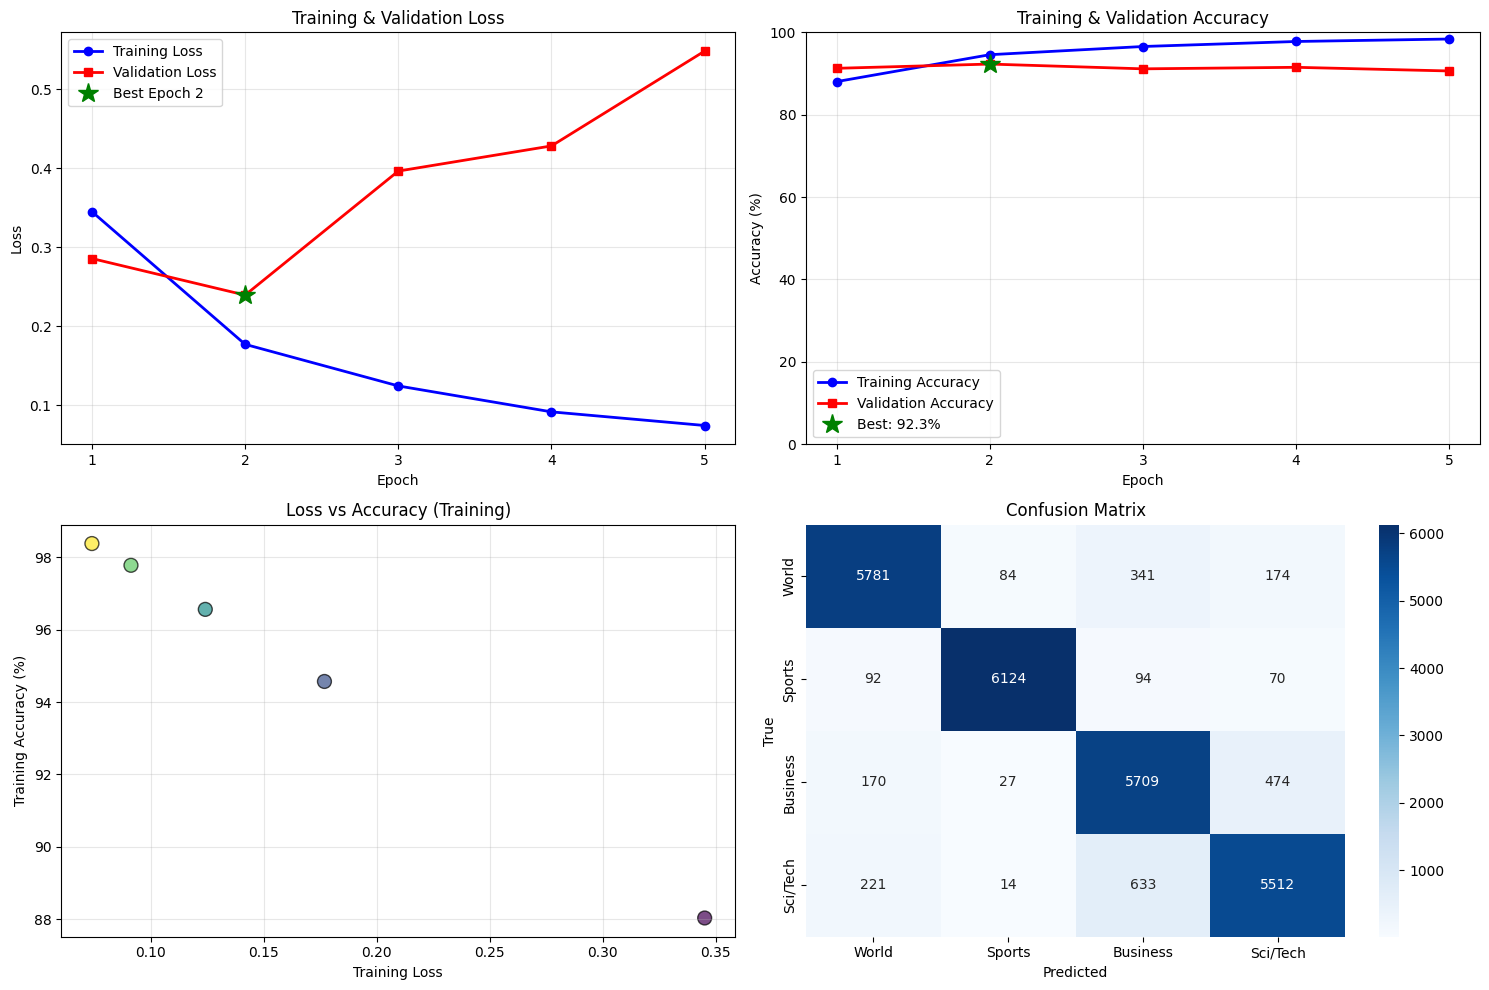

In [12]:
#Generate a PyPlot figure showing training and validation loss/accuracy, Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

#Plotting for training and validation loss
fig = plt.figure(figsize=(15,10))

#Make a subplot
ax1 = plt.subplot(2, 2, 1)
epochs_trained = range(1, len(train_losses) + 1)

#Add the epochs trained, the training and validation loss with markers and label
ax1.plot(epochs_trained, train_losses, 'b-', marker='o', linewidth=2, label='Training Loss')
ax1.plot(epochs_trained, val_losses, 'r-', marker='s', linewidth=2, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training & Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(epochs_trained)

# Add best epoch marker
if len(val_losses) > 0:
    best_epoch = val_losses.index(min(val_losses))
    ax1.plot(best_epoch + 1, val_losses[best_epoch], 'g*', markersize=15, 
             label=f'Best Epoch {best_epoch+1}')
    ax1.legend()

#Repeat the same process with training and validation accuracy
ax2 = plt.subplot(2, 2, 2)
ax2.plot(epochs_trained, train_accs, 'b-', marker='o', linewidth=2, label='Training Accuracy')
ax2.plot(epochs_trained, val_accs, 'r-', marker='s', linewidth=2, label='Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training & Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 100])
ax2.set_xticks(epochs_trained)

# Add best epoch marker for accuracy
if len(val_accs) > 0:
    best_acc_epoch = val_accs.index(max(val_accs))
    ax2.plot(best_acc_epoch + 1, val_accs[best_acc_epoch], 'g*', markersize=15,
             label=f'Best: {val_accs[best_acc_epoch]:.1f}%')
    ax2.legend()
    
#Make a scatter plot to show loss vs accuracy
# 3. Loss vs Accuracy (scatter)
ax3 = plt.subplot(2, 2, 3)
scatter = ax3.scatter(train_losses, train_accs, c=epochs_trained, cmap='viridis', 
                      s=100, alpha=0.7, edgecolors='black')
ax3.set_xlabel('Training Loss')
ax3.set_ylabel('Training Accuracy (%)')
ax3.set_title('Loss vs Accuracy (Training)')
ax3.grid(True, alpha=0.3)

#Confusion Matrix
ax4 = plt.subplot(2, 2, 4)
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot as heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=ax4)
ax4.set_xlabel('Predicted')
ax4.set_ylabel('True')
ax4.set_title('Confusion Matrix')

plt.tight_layout()
plt.show()


In [13]:
#Task 2 Setting Up a Transformer Decoder